In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
from matplotlib.patches import Patch
from skimage.draw import polygon2mask

# --- (Re-using load_dicom_series_to_hu from previous responses) ---
def load_dicom_series_to_hu(dicom_dir):
    slices = []
    for s in os.listdir(dicom_dir):
        try:
            filepath = os.path.join(dicom_dir, s)
            ds = pydicom.dcmread(filepath)
            if ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.2' and 'PixelData' in ds:
                slices.append(ds)
        except Exception:
            continue
    if not slices:
        print(f"No valid CT DICOM images found in {dicom_dir}")
        return None, None
    slices.sort(key=lambda s: float(s.ImagePositionPatient[2]))
    pixel_spacing = slices[0].PixelSpacing
    slice_thickness = float(slices[0].SliceThickness)
    spacing_between_slices = getattr(slices[0], 'SpacingBetweenSlices', slice_thickness)
    image_position_patient = np.array(slices[0].ImagePositionPatient)
    origin_3d = image_position_patient
    spacing_3d = np.array([pixel_spacing[1], pixel_spacing[0], spacing_between_slices])
    image_3d_shape = (len(slices), slices[0].Rows, slices[0].Columns)
    image_3d_hu = np.zeros(image_3d_shape, dtype=np.int16)
    for i, s in enumerate(slices):
        raw_pixel_array = s.pixel_array
        rescale_slope = getattr(s, 'RescaleSlope', 1)
        rescale_intercept = getattr(s, 'RescaleIntercept', 0)
        hu_array = raw_pixel_array * rescale_slope + rescale_intercept
        image_3d_hu[i, :, :] = hu_array
    slice_z_positions = np.array([float(s.ImagePositionPatient[2]) for s in slices])
    return image_3d_hu, {
        'origin': origin_3d,
        'spacing': spacing_3d,
        'shape': image_3d_hu.shape,
        'slice_z_positions': slice_z_positions,
        'slice_thickness': slice_thickness
    }

In [2]:
# --- NEW HELPER FUNCTION: Plot IVH for a single region ---
def plot_single_slice_ivh(hu_values, region_name, color='blue'):
    """
    Plots a histogram for a specific region's HU values from a single slice.
    """
    if hu_values.size == 0:
        print(f"No HU values to plot for {region_name}.")
        return

    plt.figure(figsize=(7, 5))
    
    # Define bin range to cover typical CT values, potentially extending for metal/artifacts
    min_hu_plot = -1024
    max_hu_plot = 5000 # Extend to capture higher artifact/metal values
    
    # Use a fixed number of bins for consistency
    bins = np.linspace(min_hu_plot, max_hu_plot, 100)

    plt.hist(hu_values, bins=bins, color=color, edgecolor='black', alpha=0.7)
    plt.title(f"IVH for {region_name} (Single Slice)", fontsize=14)
    plt.xlabel('Hounsfield Unit (HU)', fontsize=12)
    plt.ylabel('Frequency (Number of Pixels)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [3]:
def visualize_implant_artifacts_and_tissues(
    ct_hu_volume, # This is the main input you need to provide
    slice_index,
    metal_hu_threshold=2500, 
    bright_artifact_hu_ranges=[(1000, 2500)], 
    bone_hu_range=(100, 1000), 
    dark_artifact_hu_range=(-1000, -250),
    artifact_roi_margin_pixels=75 
):
    """
    Identifies and visually displays metal, bright artifacts, bone, and dark artifacts
    on a given CT slice. Artifacts are constrained to an ROI around metal.
    Also generates IVHs for each characterized region on this single slice.
    
    Args:
        ct_hu_volume (np.ndarray): The 3D NumPy array of CT scan in Hounsfield Units.
                                   This should be pre-loaded before calling this function.
        slice_index (int): The index of the 2D slice to display (0-based).
        metal_hu_threshold (int): HU value to segment the core metal implant.
        bright_artifact_hu_ranges (list of tuples): List of (min_hu, max_hu) tuples for bright artifacts.
        bone_hu_range (tuple): (min_hu, max_hu) for bone.
        dark_artifact_hu_range (tuple): (min_hu, max_hu) for dark artifacts.
        artifact_roi_margin_pixels (int): Margin in pixels to expand around the metal bounding box.
    """
    if slice_index < 0 or slice_index >= ct_hu_volume.shape[0]:
        print(f"Error: Slice index {slice_index} is out of bounds for volume with {ct_hu_volume.shape[0]} slices.")
        return

    current_slice = ct_hu_volume[slice_index, :, :]
    rows, cols = current_slice.shape
    
    # --- Characterization Logic ---

    # 1. Identify the core metal implant
    metal_mask = current_slice > metal_hu_threshold

    if not np.any(metal_mask):
        print(f"No metal detected on slice {slice_index} with threshold {metal_hu_threshold} HU. "
              "Cannot define artifact ROI and proceed with detailed characterization.")
        plt.figure(figsize=(6,6))
        plt.imshow(current_slice, cmap='gray', vmin=-150, vmax=250)
        plt.title(f"CT Slice {slice_index} (No Metal or Overlays)")
        plt.axis('off')
        plt.show()
        return

    # Find bounding box of the metal to define the ROI around it
    r_coords, c_coords = np.where(metal_mask)
    r_min_metal, r_max_metal = np.min(r_coords), np.max(r_coords)
    c_min_metal, c_max_metal = np.min(c_coords), np.max(c_coords)

    # Define the ROI around the metal by adding a margin
    r_min_roi = max(0, r_min_metal - artifact_roi_margin_pixels)
    r_max_roi = min(rows, r_max_metal + artifact_roi_margin_pixels)
    c_min_roi = max(0, c_min_metal - artifact_roi_margin_pixels)
    c_max_roi = min(cols, c_max_metal + artifact_roi_margin_pixels)
    
    artifact_roi_mask = np.zeros(current_slice.shape, dtype=bool)
    artifact_roi_mask[r_min_roi:r_max_roi, c_min_roi:c_max_roi] = True
    print(f"Defined artifact ROI around metal: rows {r_min_roi}-{r_max_roi}, cols {c_min_roi}-{c_max_roi}")

    # 2. Characterize Dark Artifacts (within the artifact_roi_mask)
    min_hu_dark, max_hu_dark = dark_artifact_hu_range
    dark_artifact_hu_mask_raw = (current_slice >= min_hu_dark) & (current_slice <= max_hu_dark)
    final_dark_artifact_mask = dark_artifact_hu_mask_raw & artifact_roi_mask
    dark_artifact_hu_values = current_slice[final_dark_artifact_mask] # Extract values here
    if np.any(final_dark_artifact_mask):
        print(f"Dark Artifacts found: Count={dark_artifact_hu_values.size}, Min HU={dark_artifact_hu_values.min():.2f}, Max HU={dark_artifact_hu_values.max():.2f}")
    else:
        print("No dark artifact pixels found in the defined ROI and HU range.")

    # 3. Characterize Bright Artifacts (within the artifact_roi_mask, EXCLUDING metal)
    print("\n--- Characterizing Bright Artifacts ---")
    bright_artifact_hu_mask_combined = np.zeros_like(current_slice, dtype=bool)
    for i, (min_hu_bright, max_hu_bright) in enumerate(bright_artifact_hu_ranges):
        bright_artifact_hu_mask_range = (current_slice >= min_hu_bright) & (current_slice <= max_hu_bright)
        bright_artifact_hu_mask_combined |= bright_artifact_hu_mask_range 
        print(f"  Step 1.{(i+1)} (Raw HU range {min_hu_bright}-{max_hu_bright}): {np.sum(bright_artifact_hu_mask_range)} pixels identified.")
    
    bright_artifact_in_roi_mask = bright_artifact_hu_mask_combined & artifact_roi_mask
    final_bright_artifact_mask = bright_artifact_in_roi_mask & ~metal_mask
    bright_artifact_hu_values = current_slice[final_bright_artifact_mask] # Extract values here
    if np.any(final_bright_artifact_mask):
        print(f"Bright Artifacts found: Count={bright_artifact_hu_values.size}, Min HU={bright_artifact_hu_values.min():.2f}, Max HU={bright_artifact_hu_values.max():.2f}")
    else:
        print("No bright artifact pixels found after all filtering.")

    # 4. Characterize Bone (within the artifact_roi_mask, EXCLUDING metal and bright artifacts)
    min_hu_bone, max_hu_bone = bone_hu_range
    bone_hu_mask_raw = (current_slice >= min_hu_bone) & (current_slice <= max_hu_bone)
     # This combines the bone mask with the ROI and excludes pixels that are already part of the metal and bright artifacts
    final_bone_mask = bone_hu_mask_raw & artifact_roi_mask & ~metal_mask & ~final_bright_artifact_mask
    bone_hu_values = current_slice[final_bone_mask] # Extract values here
    if np.any(final_bone_mask):
        print(f"Bone found: Count={bone_hu_values.size}, Min HU={bone_hu_values.min():.2f}, Max HU={bone_hu_values.max():.2f}")
    else:
        print("No bone pixels found in the defined ROI and HU range.")
    
    # Extract metal HU values (already have metal_mask)
    metal_hu_values = current_slice[metal_mask]
    if np.any(metal_mask):
        print(f"Metal Implant found: Count={metal_hu_values.size}, Min HU={metal_hu_values.min():.2f}, Max HU={metal_hu_values.max():.2f}")
    else:
        print("No metal pixels found.")

    # --- Visualization of Overlays ---
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    ax.imshow(current_slice, cmap='gray', vmin=-150, vmax=250) 
    ax.set_title(f"CT Slice {slice_index} with Characterized Regions")
    ax.axis('off')

    # Define specific RGBA colors for each category (R, G, B, Alpha)
    metal_rgba = (0.0, 1.0, 1.0, 0.7)  # Bright Cyan for Metal
    bright_artifact_rgba = (0.0, 0.7, 1.0, 0.5) # Light Blue/Cyan 
    dark_artifact_rgba = (1.0, 0.0, 1.0, 0.6) # Magenta/Purple
    bone_rgba = (1.0, 0.8, 0.0, 0.4) # Light Yellow/Orange
    roi_boundary_color = 'lime' 

    # Overlay Metal 
    if np.any(metal_mask):
        metal_overlay = np.zeros((*current_slice.shape, 4)) 
        metal_overlay[metal_mask] = metal_rgba 
        ax.imshow(metal_overlay) 

    # Overlay Bright Artifacts 
    if np.any(final_bright_artifact_mask):
        bright_overlay = np.zeros((*current_slice.shape, 4))
        bright_overlay[final_bright_artifact_mask] = bright_artifact_rgba
        ax.imshow(bright_overlay)

    # Overlay Bone 
    if np.any(final_bone_mask):
        bone_overlay = np.zeros((*current_slice.shape, 4))
        bone_overlay[final_bone_mask] = bone_rgba
        ax.imshow(bone_overlay)

    # Overlay Dark Artifacts 
    if np.any(final_dark_artifact_mask):
        dark_overlay = np.zeros((*current_slice.shape, 4))
        dark_overlay[final_dark_artifact_mask] = dark_artifact_rgba
        ax.imshow(dark_overlay)

    # Draw the automatically defined ROI boundary
    if artifact_roi_mask is not None: 
        ax.add_patch(plt.Rectangle((c_min_roi, r_min_roi), c_max_roi-c_min_roi, r_max_roi-r_min_roi,
                                    edgecolor=roi_boundary_color, facecolor='none', linewidth=2, linestyle='--', label='Auto ROI'))
    
    # Create custom legend handles using the exact RGBA colors (with full opacity for the swatch)
    legend_elements = [
        Patch(facecolor=(metal_rgba[0], metal_rgba[1], metal_rgba[2], 1.0), edgecolor='black', label='Metal Implant'),
        Patch(facecolor=(bright_artifact_rgba[0], bright_artifact_rgba[1], bright_artifact_rgba[2], 1.0), edgecolor='black', label='Bright Artifacts'),
        Patch(facecolor=(bone_rgba[0], bone_rgba[1], bone_rgba[2], 1.0), edgecolor='black', label='Bone'),
        Patch(facecolor=(dark_artifact_rgba[0], dark_artifact_rgba[1], dark_artifact_rgba[2], 1.0), edgecolor='black', label='Dark Artifacts')
    ]
    if artifact_roi_mask is not None:
        legend_elements.append(Patch(facecolor='none', edgecolor=roi_boundary_color, lw=2, ls='--', label='Auto ROI'))

    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

    # --- Generate and Display IVHs for each region on this slice ---
    print("\n--- Generating IVHs for each characterized region on this slice ---")
    plot_single_slice_ivh(metal_hu_values, "Metal Implant", color=(metal_rgba[0], metal_rgba[1], metal_rgba[2]))
    plot_single_slice_ivh(bright_artifact_hu_values, "Bright Artifacts", color=(bright_artifact_rgba[0], bright_artifact_rgba[1], bright_artifact_rgba[2]))
    plot_single_slice_ivh(bone_hu_values, "Bone", color=(bone_rgba[0], bone_rgba[1], bone_rgba[2]))
    plot_single_slice_ivh(dark_artifact_hu_values, "Dark Artifacts", color=(dark_artifact_rgba[0], dark_artifact_rgba[1], dark_artifact_rgba[2]))

Loading CT series from: C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT
CT Volume loaded with shape: (248, 512, 512)

Visualizing and characterizing regions for slice 49...
Defined artifact ROI around metal: rows 215-280, cols 82-147
No dark artifact pixels found in the defined ROI and HU range.

--- Characterizing Bright Artifacts ---
  Step 1.1 (Raw HU range 1000-2500): 900 pixels identified.
  Step 1.2 (Raw HU range 4000-6000): 8 pixels identified.
Bright Artifacts found: Count=437, Min HU=1005.00, Max HU=2218.00
Bone found: Count=243, Min HU=300.00, Max HU=998.00
Metal Implant found: Count=26, Min HU=2574.00, Max HU=7706.00


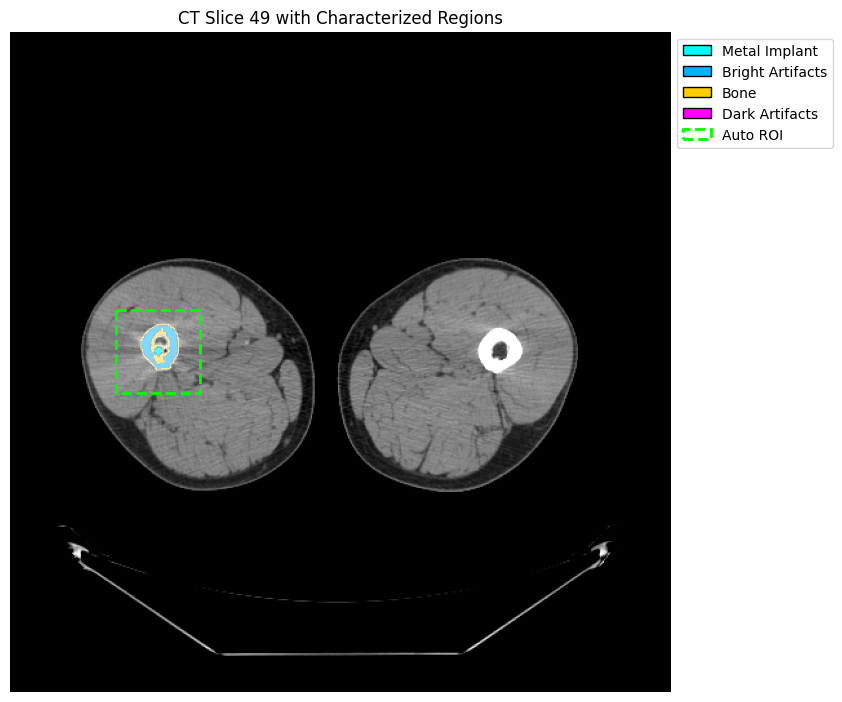


--- Generating IVHs for each characterized region on this slice ---


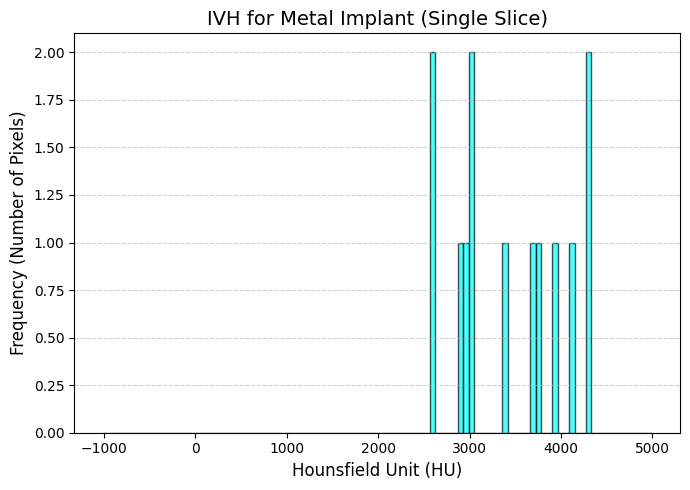

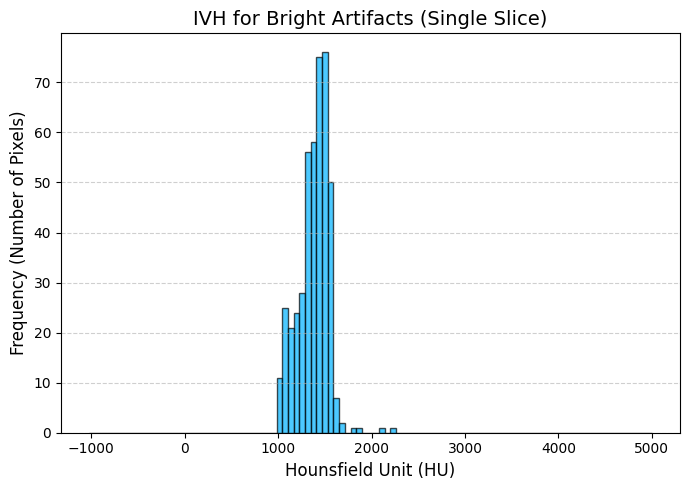

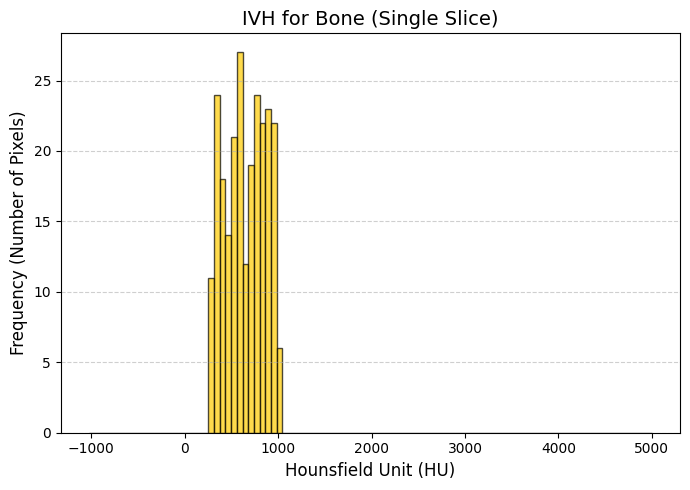

No HU values to plot for Dark Artifacts.


In [5]:
# --- Main Execution Example ---
if __name__ == "__main__":
    # IMPORTANT: REPLACE THESE WITH YOUR ACTUAL PATHS
    ct_series_directory = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT"
    
    # The RTSTRUCT file is not directly used in this specific visualization function,
    # but it's kept here as it's typically part of your overall project context.
    rtstruct_file_path = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 RSTRUCT\2.16.840.1.114362.1.12177026.23360333229.708561731.777.13.dcm" 

    if not os.path.isdir(ct_series_directory):
        print(f"Error: CT series directory not found at '{ct_series_directory}'. Please update the path.")
    else:
        print(f"Loading CT series from: {ct_series_directory}")
        ct_hu_volume, ct_spatial_meta = load_dicom_series_to_hu(ct_series_directory)

        if ct_hu_volume is None:
            print("Failed to load CT volume. Exiting.")
        else:
            print(f"CT Volume loaded with shape: {ct_hu_volume.shape}")

            slice_to_analyze = ct_hu_volume.shape[0] // 5

            # --- Define your HU thresholds/ranges ---
            metal_thresh = 2500 
            bright_artifact_range_vals = [(1000, 2500), (4000, 6000)] 
            bone_range_vals = (300, 1300) 
            dark_artifact_range_vals = (-1000, -150) 
            artifact_margin_pixels_val = 30 

            print(f"\nVisualizing and characterizing regions for slice {slice_to_analyze}...")
            visualize_implant_artifacts_and_tissues(
                ct_hu_volume,
                slice_to_analyze,
                metal_hu_threshold=metal_thresh,
                bright_artifact_hu_ranges=bright_artifact_range_vals, 
                bone_hu_range=bone_range_vals,
                dark_artifact_hu_range=dark_artifact_range_vals,
                artifact_roi_margin_pixels=artifact_margin_pixels_val
            )